In [1]:
# import data from the SR datasets.
# visualise the pareto frontier (accuracy vs cost) for a selected config

In [2]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys

repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier

In [3]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [4]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [5]:
# GENERATION_CONFIG
BASELINE_K=5
BASELINE_TEMP=0.6

ROUTING_MAX_K=5
ROUTING_TEMP=0.6

In [6]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"
        else:
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS

In [7]:
BASELINE_BENCHMARK_DF.head(2)

,problem,formatted_prompt,ground_truth,generated_solutions,total_input_tokens,total_output_tokens,total_cost_usd,input_cost_usd_once,success_rate,model_name,task,split,problem_id,total_output_cost_usd,majority_vote_extracted_answer,majority_vote_is_correct
0,How many vertical asymptotes does the graph of...,<|im_start|>system\nPlease reason step by step...,2,[{'input_cost_usd_once': 3.9031999999999995e-0...,68,1603,0.002798,0.000039,1.0,Qwen/Qwen2.5-Math-72B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,0.002759,2,1.0
1,What is the positive difference between $120\%...,<|im_start|>system\nPlease reason step by step...,10,[{'input_cost_usd_once': 4.190199999999999e-05...,73,1256,0.002203,0.000042,1.0,Qwen/Qwen2.5-Math-72B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,0.002162,10,1.0


In [8]:
PLOTTING_DICT

{'opencompass_AIME2025': [{'name': 'Qwen-Qwen2.5-Math-1.5B-Instruct',
   'passk_score': 0.14666666666666667,
   'majority_vote_score': 0.2,
   'cost': 0.0067124},
  {'name': 'Qwen-Qwen2.5-Math-7B-Instruct',
   'passk_score': 0.09333333333333334,
   'majority_vote_score': 0.06666666666666667,
   'cost': 0.030158232999999996},
  {'name': 'Qwen-Qwen2.5-Math-72B-Instruct',
   'passk_score': 0.09333333333333334,
   'majority_vote_score': 0.06666666666666667,
   'cost': 0.18583089399999997}],
 'gneubig_aime-1983-2024': [{'name': 'Qwen-Qwen2.5-Math-1.5B-Instruct',
   'passk_score': 0.2728831725616292,
   'majority_vote_score': 0.31189710610932475,
   'cost': 0.45490720000000007},
  {'name': 'Qwen-Qwen2.5-Math-7B-Instruct',
   'passk_score': 0.259807073954984,
   'majority_vote_score': 0.3086816720257235,
   'cost': 1.841548014},
  {'name': 'Qwen-Qwen2.5-Math-72B-Instruct',
   'passk_score': 0.3007502679528403,
   'majority_vote_score': 0.3612004287245445,
   'cost': 10.779033793}],
 'openai_g

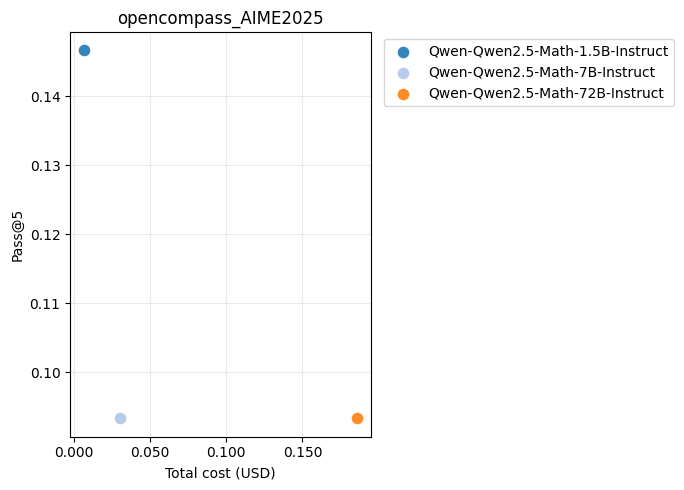

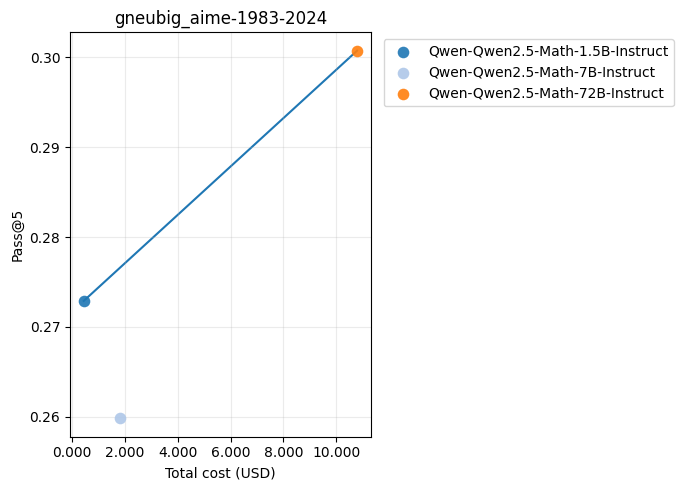

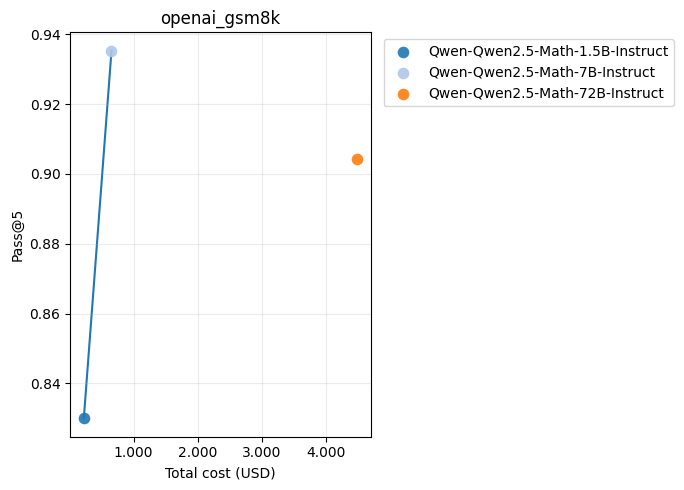

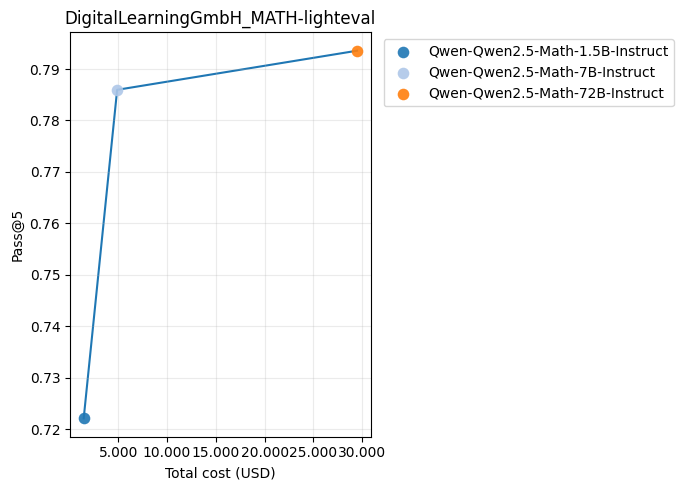

In [9]:
for benchmark, data_points in PLOTTING_DICT.items():
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@{BASELINE_K}")

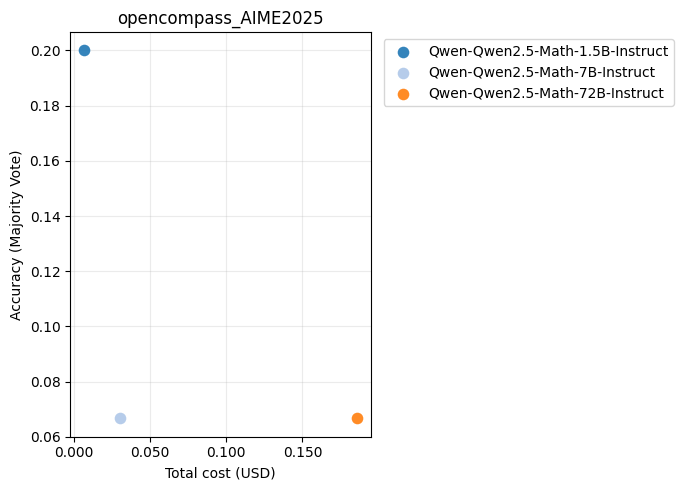

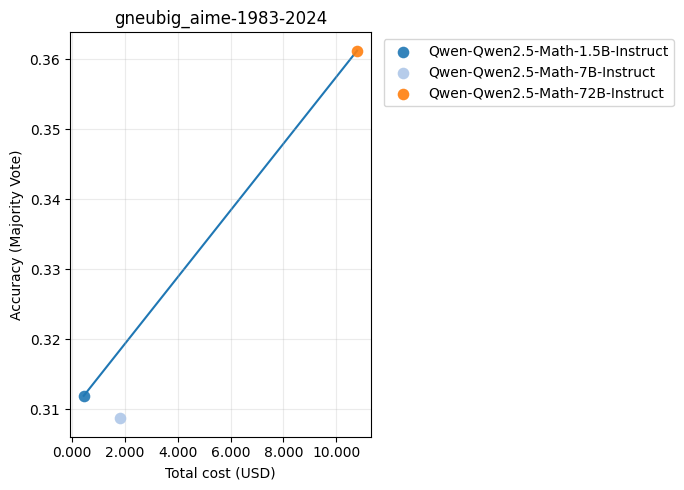

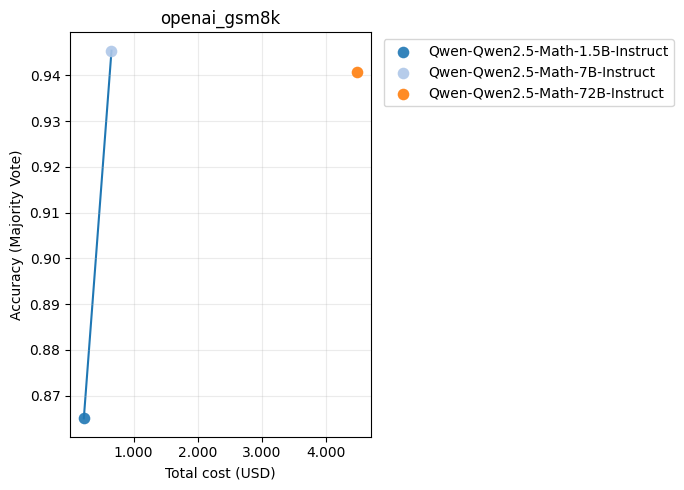

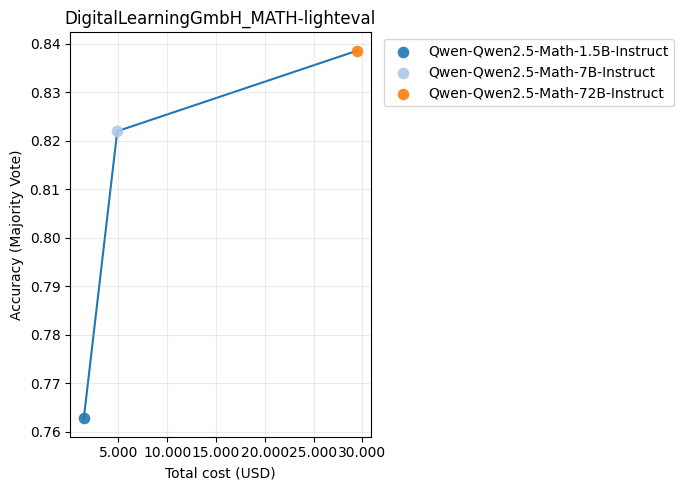

In [10]:
for benchmark, data_points in PLOTTING_DICT.items():
    plot_pareto_frontier(data_points, benchmark, score_col="majority_vote_score", x_label="Total cost (USD)", y_label=f"Accuracy (Majority Vote)")

In [11]:
PIKA_V2_DIR = f"pika_router_runs/{BASELINE_BENCHMARK_ALIAS}_routed_by_{BASELINE_BENCHMARK_ALIAS}_Qwen_Qwen2.5-Math-1.5B-Instruct_probeK{BASELINE_K}_probeT{BASELINE_TEMP}_routeK{ROUTING_MAX_K}_routeT{ROUTING_TEMP}_sc_final.parquet"
PIKA_V2_DIR = f"pika_router_runs/DigitalLearningGmbH_MATH-lighteval_routed_by_DigitalLearningGmbH_MATH-lighteval_Qwen_Qwen2.5-Math-1.5B-Instruct_probeK5_probeT0.6_routeK5_routeT0.6_sc_easy-5_hard-1_medium-5_threshE0.8_M0.4.parquet"

In [12]:
pika_df = pd.read_parquet(PIKA_V2_DIR)

In [13]:
pika_sr_score = pika_df["passk_score"].mean()
pika_majority_vote_score = pika_df["majority_vote_is_correct"].mean()
pika_total_cost = pika_df["total_cost_usd"].sum()

In [14]:
PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": "PIKA ROUTER (k between 1-5)", "kind": "router", "passk_score": pika_sr_score, "majority_vote_score":pika_majority_vote_score, "cost": pika_total_cost}]

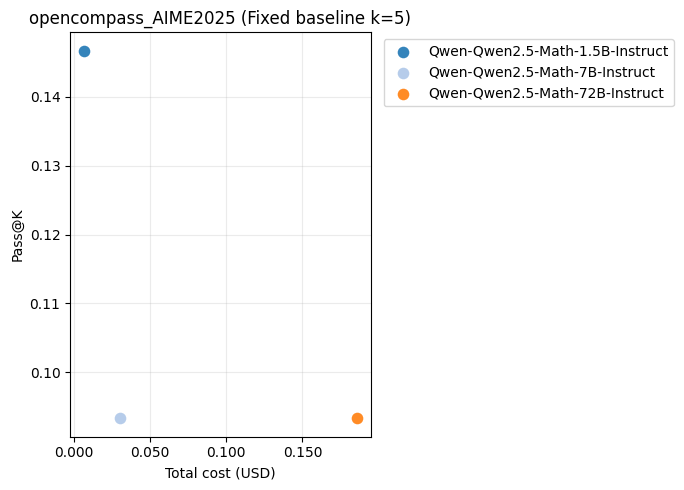

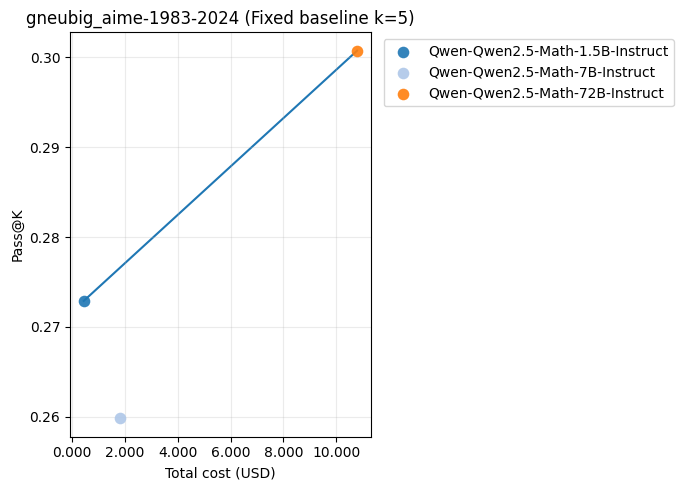

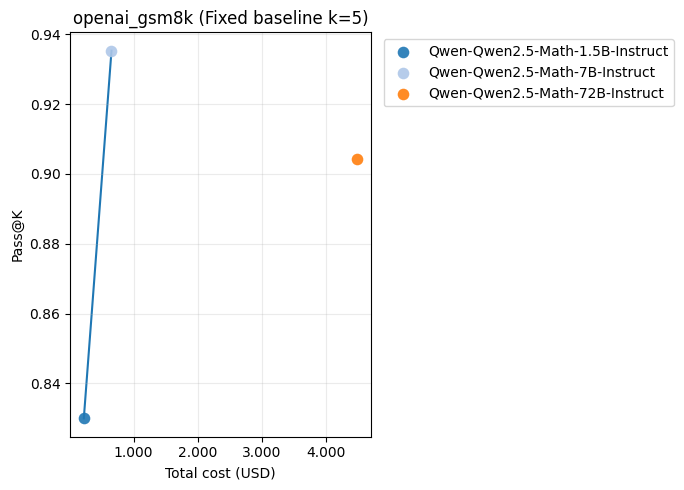

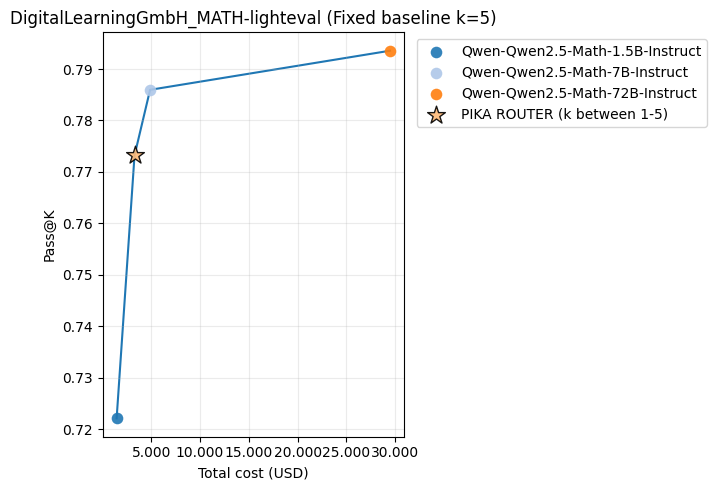

In [15]:
for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += " (greedy)"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@K")

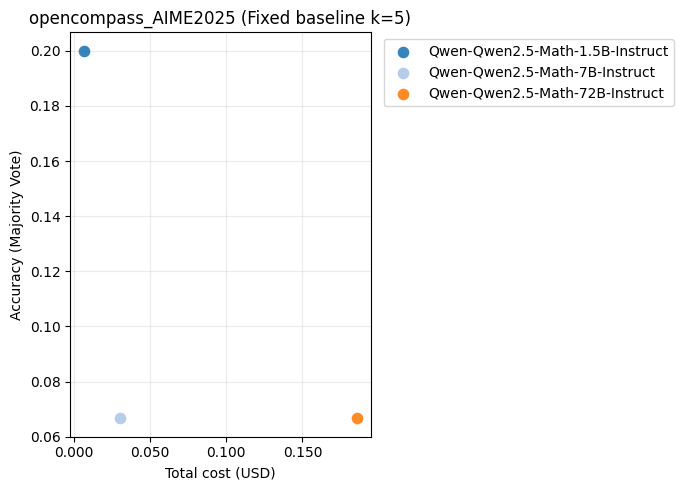

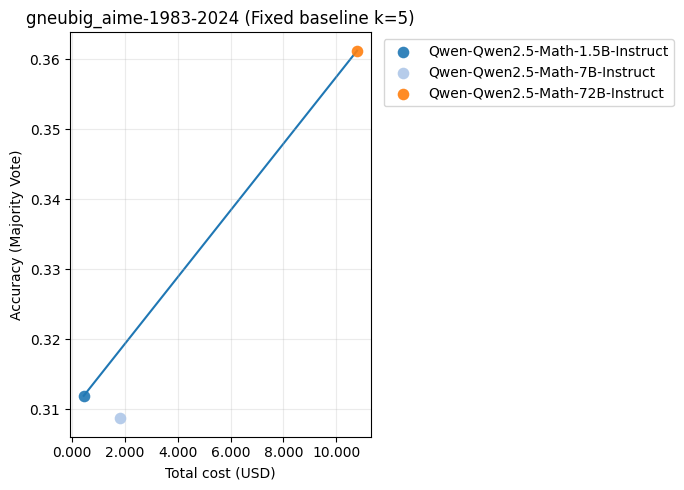

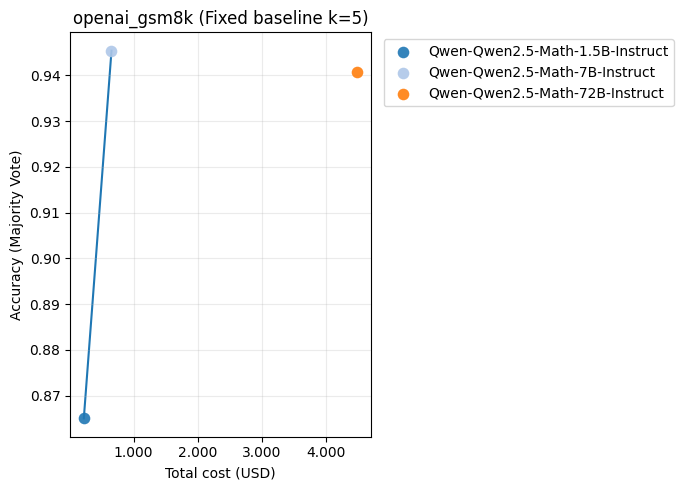

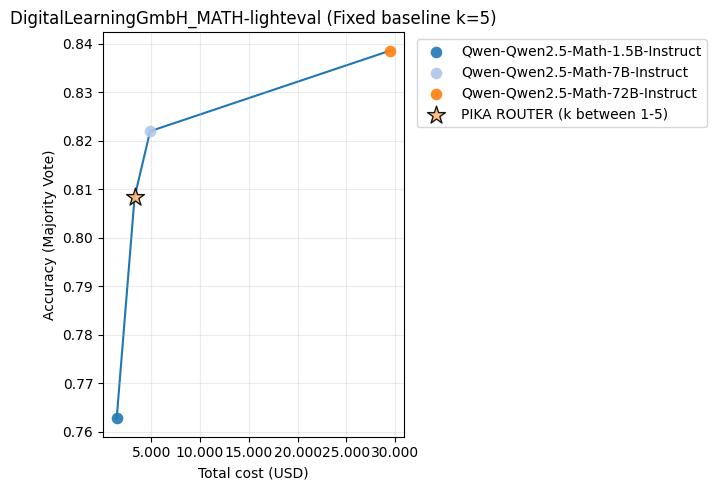

In [16]:
for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += " (greedy)"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="majority_vote_score", x_label="Total cost (USD)", y_label=f"Accuracy (Majority Vote)")